# Validation


## Overview


The goal of the Niche Validation is to compare the potential vegetation types as
determined by Niche Vlaanderen with the actual presence of vegetation types, eg
as mapped in the [Biologische waarderingskaart (BWK)]( https://www.vlaanderen.be/inbo/de-biologische-waarderingskaart/wat-is-de-biologische-waarderingskaart/)

The BWK vector file contains up to 5 habitat types in field HAB1-HAB5 and their
proportion of the shape in fields pHAB1-pHAB5.

This vegetation types in BWK are different from those in niche, but a [mapping
table](https://github.com/inbo/niche_vlaanderen/blob/calibration/niche_vlaanderen/system_tables/hab_niche_join.csv) exists that links both.

In the next steps, a (fictive) niche model is created. Vegetation type 5 is plotted because this will be used further as an example.

<AxesSubplot: title={'center': 'Carpinion betuli (5)'}>

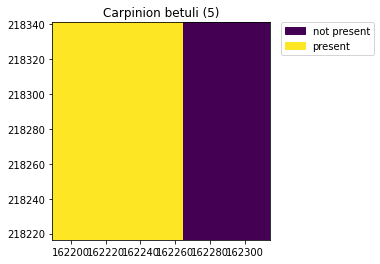

In [1]:
from niche_vlaanderen import Niche
nv = Niche()
nv.run_config_file("../tests/data/bwk_tiny/tiny.yaml")
nv.plot(5)

Next an overlay object is created which contains the bwk map with extra columns NICH_x_y for the corresponding niche vegetation types. Note that some vegetation types can not be mapped to niche (eg `gh` in the example below).
Next the `zonal_statistics` module is used to calculate the potential vegetation for every shape.

Note the progress bar, in this example it is going fast, but for larger areas, calculation may take up to 10 minutes.

In [2]:
from niche_vlaanderen.validation import NicheValidation
validation = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.66it/s]


It is possible to check the mapping per vegetation type by checking the map attribute of the overlay object

In [3]:
validation.map

,HAB1,pHAB1,HAB2,pHAB2,HAB3,pHAB3,HAB4,pHAB4,HAB5,pHAB5,...,NICH_1_1,NICH_1_2,NICH_2_1,NICH_2_2,NICH_3_1,NICH_3_2,NICH_4_1,NICH_4_2,NICH_5_1,NICH_5_2
0,2310,100,None,0,None,0,None,0,None,0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2190_mp,100,None,0,None,0,None,0,None,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rbbsm,100,None,20,None,0,None,0,None,0,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gh,80,rbbvos,20,None,0,None,0,None,0,...,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9160,100,None,0,None,0,None,0,None,0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The actual overlay will compare the grid cell centres with the shapefile. By default a upscaling factor of 5 (25 points per grid cell) is used to ensure sufficient coverage of the shapefile. For niche models of 20-25m resolution, this default value will lead to a spatial resolution of 1m, which is sufficient given the scale of the BWK map.
![comparison between 1 and 5 upscaling](_static/png/bwk_overlay.png)

If upscaling is not used and set to one, only the grid center will be used, which may lead to warnings because some shapes are not covered. 

In [4]:
validation1 = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp", upscale=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.99it/s]
/home/johan/Nextcloud/_proj/niche/niche_vlaanderen/niche_vlaanderen/validation.py:191: UserWarning: No overlap between potential vegetation map and shape_id 0
  warnings.warn(
/home/johan/Nextcloud/_proj/niche/niche_vlaanderen/niche_vlaanderen/validation.py:191: UserWarning: No overlap between potential vegetation map and shape_id 2
  warnings.warn(


A summarized table containing scores of the overlay can be found by calling the summary method.

In [5]:
validation.summary

,area_effective,nonpot,nonpot_opt,pot,polygon_count,score,score_opt
vegetation,,,,,,,
5,0.600058,0.014945,0.019679,0.580379,1.0,97.48954,96.720418
19,0.071813,0.358689,0.071813,0.000000,1.0,0.00000,0.000000
27,0.004235,0.004982,0.004235,0.000000,1.0,0.00000,0.000000
28,0.006143,0.004982,0.006143,0.000000,1.0,0.00000,0.000000


Intermediate tables giving values  can be retrieved by their names:

* area_pot: area with actual presence and potential presence predicted by niche
* area_nonpot: area with actual presence without potential presence by niche
* area_nonpot_optimistic: area with actual presence but without potential presence by niche
* area_pot_perc: proportion (%) of the area with correct predicted area (not taking into account pHab)
* area_pot_perc_optimistic: proportion (%) of the area with correct predicted area (taking into account pHab)
* area_effective: area of the shape in ha taking into account the proportion of the vegetation (pHab)
* veg_present: table showing whether vegetation is present in this polygon (1 or 0)

In [6]:
validation.area_nonpot

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.004982
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.004982,NaN
3,NaN,0.358689,NaN,NaN
4,0.014945,NaN,NaN,NaN


In [7]:
validation.area_nonpot_optimistic

vegetation,5,19,27,28
shape_id,,,,
0,NaN,NaN,NaN,0.006143
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.004235,NaN
3,NaN,0.071813,NaN,NaN
4,0.019679,NaN,NaN,NaN


## Using a custom vegetation table

When creating a validation, it is possible to supply a custom mapping table between the vegetation types in the map and niche types. This file must be a csv with two columns, HAB and NICHE, containing the vegetation type on the map in the HAB column, 

In [9]:
validation1 = NicheValidation(niche=nv, map="../tests/data/bwk_tiny/bwk_clip.shp", mapping_file="../tests/data/hab_niche_test.csv")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 66.16it/s]


## Storing the analysis
Finally, the whole project can be saved. This will save the summary tables and the intermediate tables in a folder, and create a shapefile which contains the BWK map with all intermediate tables joined to it.

In [ ]:
validation.write('_validation', overwrite=True)

In [ ]:
import os
os.listdir('_validation')